In [1]:
import torch
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import numpy as np
from matplotlib import pyplot as plt
from tensorboardX import SummaryWriter

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

/home/rene/miniconda3/envs/tscl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMG_SIZE = (128, 128)
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

In [3]:
train_dataset = datasets.ImageFolder('../lfw', transform=transform)
train_dataset

Dataset ImageFolder
    Number of datapoints: 13233
    Root location: ../lfw
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

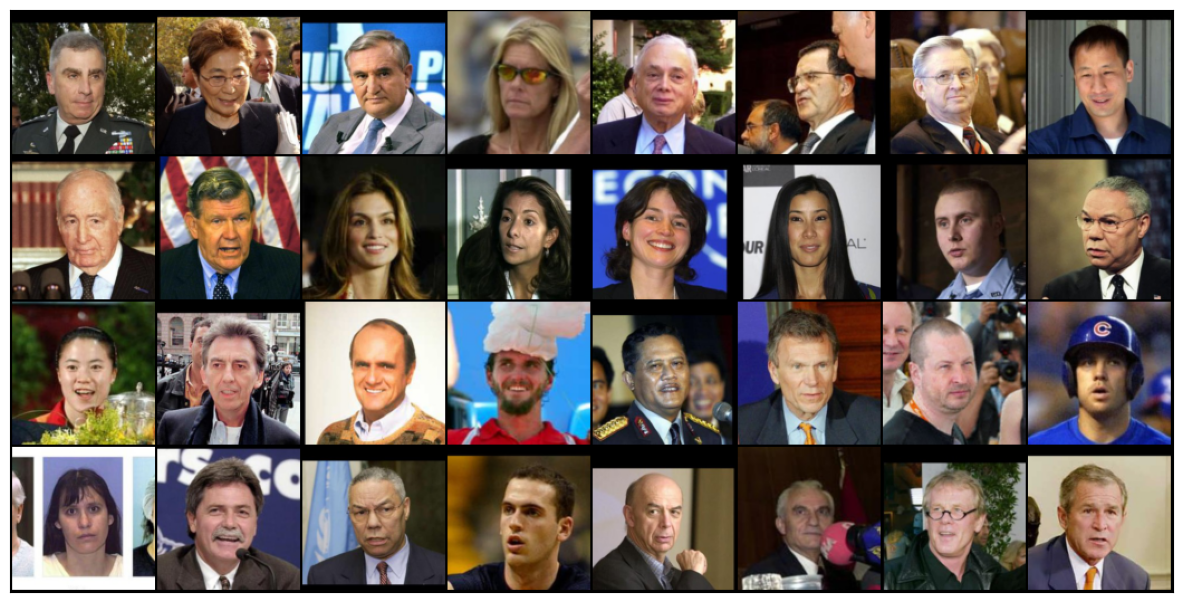

In [4]:
BATCH_SIZE = 32

g = torch.Generator()
g.manual_seed(SEED)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g)

real_sample, _ = next(iter(train_loader))

img_grid = utils.make_grid(real_sample).numpy()
img_grid_show = np.transpose(img_grid, (1, 2, 0))

plt.figure(figsize= (15,15))
plt.imshow(img_grid_show)
plt.xticks([])
plt.yticks([])
plt.show()

real_sample = real_sample.cuda()

In [5]:
from model import VAE

In [6]:
def kl_loss(mu, log_var):
    # TODO: dividir entre el numero de batches? 
    return -0.5 * torch.mean(1 + log_var - mu.pow(2) - torch.exp(log_var))

def r_loss(y_train, y_pred):
    r_loss = torch.mean((y_train - y_pred) ** 2)
    return r_loss



In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
INPUT_SHAPE = next(iter(train_loader))[0].shape[-3:]
Z_DIM = 1024
CONV_BLOCKS = 6
SAMPLE_SIZE = 32
LR = .0001
R_LOSS_FACTOR = 1
EPOCHS = 10
VISUALIZE_EVERY = 200

writer = SummaryWriter(comment='-' + 'VAE-' + str(IMG_SIZE) + '-' + str(Z_DIM) + '-' + str(CONV_BLOCKS) + '-' + str(R_LOSS_FACTOR))
writer.add_image('preview-real-sample', img_grid)

vae = VAE(INPUT_SHAPE, Z_DIM, CONV_BLOCKS).to(device)
optimizer = optim.Adam(vae.parameters(), lr=LR)

latent_space_test_points = np.random.normal(scale=1.0, size=(SAMPLE_SIZE, Z_DIM))
latent_space_test_points_v = torch.Tensor(latent_space_test_points).to(device)

In [9]:
batch_iterations = 0
training_losses = []
vae.train()

for e in range(EPOCHS):
    epoch_loss = []
    epoch_batches = 0
    for images, labels in train_loader:
        images_v = images.to(device)

        optimizer.zero_grad()

        mu_v, log_var_v, images_out_v = vae(images_v)
        r_loss_v = r_loss(images_out_v, images_v)
        kl_loss_v = kl_loss(mu_v, log_var_v)
        loss = kl_loss_v + r_loss_v * R_LOSS_FACTOR
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

        if (batch_iterations+1) % VISUALIZE_EVERY == 0:
            # print loss
            print(f"Epoch: {e}\tBatch: {epoch_batches + 1}\tLoss: {loss.item()}")
            writer.add_scalar('loss', np.mean(epoch_loss[-VISUALIZE_EVERY:]), batch_iterations + 1)

            vae.eval()

            generated_imgs_v = vae.forward_decoder(latent_space_test_points_v).detach()
            imgs_grid = utils.make_grid(generated_imgs_v)

            writer.add_image('preview-latent-sample-decoded', imgs_grid.cpu().numpy(), batch_iterations + 1)

            reconstructed_real_sample = vae.forward(real_sample)[2].detach()
            imgs_grid = utils.make_grid(reconstructed_real_sample)

            writer.add_image('preview-real-sample-reconstructed', imgs_grid.cpu().numpy(), batch_iterations + 1)

            vae.train()



        batch_iterations = batch_iterations + 1
        epoch_batches = epoch_batches + 1

    training_losses.append(np.mean(epoch_loss))
    if min(training_losses) == training_losses[-1]:
        vae.save('trained/vae-' + str(IMG_SIZE) + '-' + str(Z_DIM) + '-' + str(CONV_BLOCKS) + '-' + str(R_LOSS_FACTOR) + '.dat')

    # vae.eval()

    # generated_imgs_v = vae.forward_decoder(latent_space_test_points_v).detach()
    # imgs_grid = utils.make_grid(generated_imgs_v)

    # writer.add_image('preview-2', imgs_grid.cpu().numpy(), batch_iterations)

    # vae.train()


Epoch: 0	Batch: 200	Loss: 0.07608582824468613
Epoch: 0	Batch: 400	Loss: 0.07189872115850449
Epoch: 1	Batch: 186	Loss: 0.061746932566165924
Epoch: 1	Batch: 386	Loss: 0.06107885390520096
Epoch: 2	Batch: 172	Loss: 0.05974888056516647
Epoch: 2	Batch: 372	Loss: 0.05860450491309166
Epoch: 3	Batch: 158	Loss: 0.05401355028152466
Epoch: 3	Batch: 358	Loss: 0.054704874753952026
Epoch: 4	Batch: 144	Loss: 0.05432421341538429
Epoch: 4	Batch: 344	Loss: 0.057046886533498764
Epoch: 5	Batch: 130	Loss: 0.049810972064733505
Epoch: 5	Batch: 330	Loss: 0.05246097594499588
Epoch: 6	Batch: 116	Loss: 0.05660880357027054
Epoch: 6	Batch: 316	Loss: 0.05196402966976166
Epoch: 7	Batch: 102	Loss: 0.04462772607803345
Epoch: 7	Batch: 302	Loss: 0.052425894886255264
Epoch: 8	Batch: 88	Loss: 0.049995094537734985
Epoch: 8	Batch: 288	Loss: 0.04894760623574257
Epoch: 9	Batch: 74	Loss: 0.0500350184738636
Epoch: 9	Batch: 274	Loss: 0.04412408173084259
